# UNET

Some ChatGPT was used, most notably to debug the UNET

#### Libraries

In [33]:
import torch
import torch.nn as nn
import datetime
import torch.optim as optim
import torch.nn.functional as F 
import torchvision
from torchvision import datasets, transforms
import math
import matplotlib.pyplot as plt
import torchvision.utils as vutils

#### Parameters

In [34]:
"""
batchsize: 1 12 24
train epoch: 1 20 100
lr: 1e-2 1e-4
"""

# BEST PARAMETERS: batch=24, train_epoch=1, lr=1e-4

# Model parameters
batch_size = 100
lr = 1e-4
train_epoch = 1
img_size = 32
timesteps = 50
dataset_path = "./datasets"


device = torch.device(0 if torch.cuda.is_available() else "cpu")

# Resize and preprocess the images 
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=([0.5]), std=([0.5]))
])

trainset = datasets.LFWPeople(dataset_path, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
images, labels = next(iter(train_loader))       # Create a dataloader

Files already downloaded and verified


#### Model

In [35]:
class Block(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=3, upsample=False, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.norm1 = nn.GroupNorm(8, channel_in, affine=True, eps=1e-4)
        self.conv1 = nn.Conv2d(channel_in, channel_in, kernel_size, stride, kernel_size // 2)
        self.norm2 = nn.GroupNorm(8, channel_in, affine=True, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)
        self.skip_conv = nn.Conv2d(channel_in, channel_out, kernel_size, stride, kernel_size // 2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest") if upsample else None
        self.act_fnc = nn.ELU()

    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        x = self.act_fnc(self.norm1(x))
        skip = self.skip_conv(x)
        x = self.act_fnc(self.norm2(self.conv1(x)))
        x = self.conv2(x)
        return x + skip

class EncoderDecoder(nn.Module):
    def __init__(self, channels, ch=64, blocks=(1, 2, 4), is_encoder=True):
        super().__init__()
        widths = list(blocks) if is_encoder else list(blocks)[::-1]
        next_widths = widths[1:] + [widths[-1]] if is_encoder else widths[:-1]
        next_widths = [w * ch for w in next_widths]
        widths = [w * ch for w in widths]

        if is_encoder:
            self.initial_conv = nn.Conv2d(channels, widths[0], 3, 1, 1)
            self.blocks = nn.ModuleList([
                Block(w_in, w_out, downsample=True)
                for w_in, w_out in zip(widths, next_widths)
            ])
        else:
            self.initial_block = Block(widths[0], widths[0], downsample=False)
            self.blocks = nn.ModuleList([
                Block(w_in * 2, w_out, upsample=True)
                for w_in, w_out in zip([widths[0]] + widths[:-1], widths)
            ])

        self.final_conv = None if is_encoder else nn.Conv2d(widths[-1] * 2, channels, 3, 1, 1)

    def forward(self, x, skip_list=None):
        if skip_list is None:  # Encoding the images (first part Unet)
            x = self.initial_conv(x)
            skip_list = [x]
            for block in self.blocks:
                x = block(x)
                skip_list.append(x)
            return x, skip_list
        else:           # Decoding the images (second part)
            x = self.initial_block(x)
            for block in self.blocks:
                skip = skip_list.pop()
                x = torch.cat((x, skip), dim=1)
                x = block(x)
            skip = skip_list.pop()
            x = torch.cat((x, skip), dim=1)
            return self.final_conv(x)

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class UNet(nn.Module):
    def __init__(self, channel_in=3, ch=32, blocks=(1, 2, 4)):
        super().__init__()
        # Time embedding MLP
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(ch),  # Use `ch` here for consistency
            nn.Linear(ch, 2 * ch),
            nn.GELU(),
            nn.Linear(2 * ch, ch),
            nn.GELU()
        )

        # Encoder and decoder
        self.encoder = EncoderDecoder(channel_in, ch, blocks, is_encoder=True)
        self.decoder = EncoderDecoder(channel_in, ch, blocks, is_encoder=False)

    def forward(self, x, index):
        index_features = self.time_mlp(index)
        bottleneck, skip_list = self.encoder(x)
        recon_img = self.decoder(bottleneck, skip_list=skip_list)
        return recon_img



#### Noise manager

In [36]:
def cosine_alphas_bar(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, steps, steps)
    alphas_bar = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_bar = alphas_bar / alphas_bar[0]
    return alphas_bar[:timesteps]

#### Init model

In [37]:
u_net = UNet(channel_in=images.shape[1], ch=32, blocks=(1, 2, 4)).to(device)

optimizer = optim.Adam(u_net.parameters(), lr=lr)       # Adam optimizer
lr_schedule = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_epoch, eta_min=0)

loss_log = []

alphas = torch.flip(cosine_alphas_bar(timesteps), (0,)).to(device)

print("init finished")

init finished


#### Training

In [38]:
u_net.train()
for epoch in range(train_epoch):
    for num_iter, (images, labels) in enumerate(train_loader):

        if num_iter % 1000 == 0:
            now = datetime.datetime.now()
            print(num_iter, now.time())

        images = images.to(device)
        bs = images.shape[0]    # Mini-batch

        rand_index = torch.randint(timesteps, (bs,), device=device)
        random_sample = torch.randn_like(images)
        alpha_batch = alphas[rand_index].reshape(bs, 1, 1, 1)

        noise_input = alpha_batch.sqrt() * images + (1 - alpha_batch).sqrt() * random_sample

        img_pred = u_net(noise_input, rand_index)

        loss = F.l1_loss(img_pred, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log the generator training loss
        loss_log.append(loss.item())

    lr_schedule.step()

print("FINISHED")

0 23:01:09.241658
FINISHED


#### Plot loss

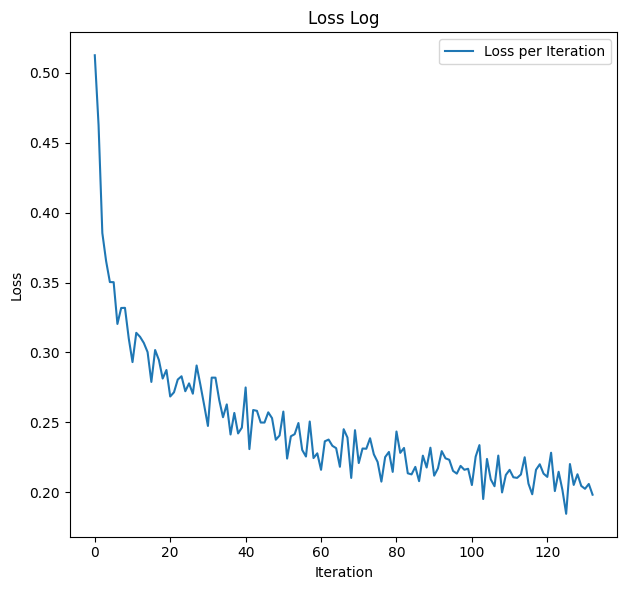

In [39]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(loss_log, label="Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Log")
plt.legend()

plt.tight_layout()
plt.show()

#### Save model

In [40]:
current_datetime = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = (
    f'img_pred_output_{current_datetime}_bs{batch_size}_lr{lr}_epoch{train_epoch}_img{img_size}.png'
)

# Save the prediction as an image
plt.figure(figsize=(20, 10))
out = vutils.make_grid(img_pred.detach().cpu(), nrow=16, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')  # Hide axes

plt.savefig("./output_img/" + filename, bbox_inches='tight')  # Save the image
plt.close()  # Close the figure